In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import pandas as pd
import scipy.optimize as op
import corner
import scipy.constants as const

In [2]:
plt.rcParams.update({'font.size':16})

## 1.) Plot the Uncerntainty Ellipse

In [3]:
# read in data

data = np.genfromtxt('data/data_p1.txt', usecols = range(3));
x_data = data[4:,0];
y_data = data[4:,1];
y_err = data[4:,2];

n_data = len(x_data)

In [4]:
degree = 1

a_mat = np.expand_dims(x_data, axis = 1)**(range(degree + 1))

cov_inv = (a_mat.T/y_err**2).dot(a_mat)
cov = np.linalg.solve(cov_inv, np.identity(2))

suff_stat = (a_mat.T/y_err**2).dot(y_data)

theta = cov.dot(suff_stat)

In [5]:
x_data_2 = data[:,0];
y_data_2 = data[:,1];
y_err_2 = data[:,2];

n_data_2 = len(x_data_2)

In [6]:
# construct linalg object

a_mat_2 = np.expand_dims(x_data_2, axis = 1)**(range(degree + 1))

cov_inv_2 = (a_mat_2.T/y_err_2**2).dot(a_mat_2)
cov_2 = np.linalg.solve(cov_inv_2, np.identity(2))

suff_stat_2 = (a_mat_2.T/y_err_2**2).dot(y_data_2)

theta_2 = cov_2.dot(suff_stat_2)

In [7]:
# calculate eigenvalue, eigencalue, and rotation

e_val_1, e_vec_1 = np.linalg.eig(cov)
rot_1 = np.arctan(e_vec_1[1,0]/e_vec_1[0,0])

e_val_2, e_vec_2 = np.linalg.eig(cov_2)
rot_2 = np.arctan(e_vec_2[1,0]/e_vec_2[0,0])

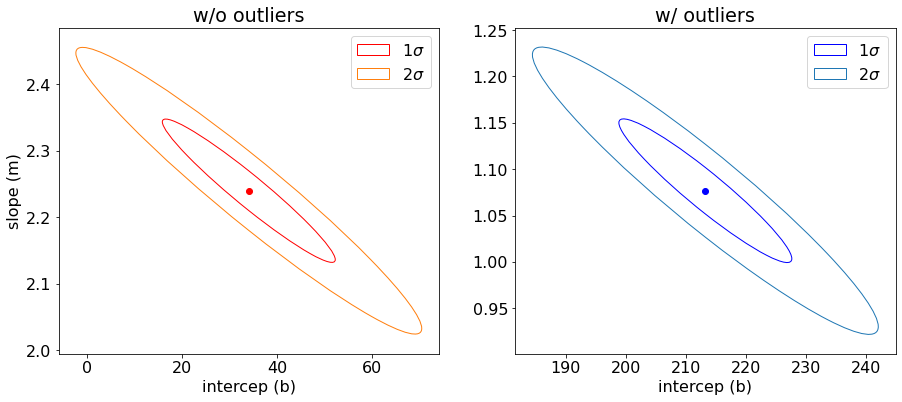

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ellipse_1 = Ellipse(xy = (theta), width = 2*np.sqrt(e_val_1[0]), height = 2*np.sqrt(e_val_1[1]), 
                 facecolor = 'None', edgecolor = 'red', 
                    angle = rot_1/const.degree, label = '$1\sigma$')

ellipse_1_2sig = Ellipse(xy = (theta), width = 4*np.sqrt(e_val_1[0]), height = 4*np.sqrt(e_val_1[1]), 
                 facecolor = 'None', edgecolor = 'tab:orange', 
                         angle = rot_1/const.degree, label = '$2\sigma$')


ellipse_2 = Ellipse(xy = (theta_2), width = 2*np.sqrt(e_val_2[0]), height = 2*np.sqrt(e_val_2[1]), 
                 facecolor = 'None', edgecolor = 'blue', 
                    angle = rot_2/const.degree, label = '$1\sigma$')

ellipse_2_2sig = Ellipse(xy = (theta_2), width = 4*np.sqrt(e_val_2[0]), height = 4*np.sqrt(e_val_2[1]), 
                 facecolor = 'None', edgecolor = 'tab:blue', 
                         angle = rot_2/const.degree, label = '$2\sigma$')

ax[0].add_patch(ellipse_1)
ax[0].add_patch(ellipse_1_2sig)
ax[0].scatter(theta[0], theta[1], c = 'red')
ax[0].legend()

ax[1].add_patch(ellipse_2)
ax[1].add_patch(ellipse_2_2sig)
ax[1].scatter(theta_2[0], theta_2[1], c = 'blue')
ax[1].legend()

ax[0].set_xlabel('intercep (b)')
ax[1].set_xlabel('intercep (b)')

ax[0].set_ylabel('slope (m)')

ax[0].set_title('w/o outliers')
ax[1].set_title('w/ outliers')

plt.show()

The error ellipse looks similar in both case because the covariance matrix does not depend on the y-data. Since in both cases almost identical x-data were used, it goes with no surprise that the error ellipse looks similar.

## 2.) Uncertainty in the Second Period After Profiling

In [9]:
# read in and plot data

data_q2 = pd.read_pickle('data/data.pkl').T

t_ar = data_q2[0]
n_obs = len(t_ar)

err = data_q2[1]

data_q2 = data_q2[12]

In [10]:
def chi2_2_freq_op(theta, t_ar, data, err, omega = 2*np.pi/100):
    #print(len(err))
    n_obs = len(t_ar)
    omega2 = 2*np.pi/theta[-1]
    theta = theta[:-1]
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    #print(theta)
    #print(a_mat.dot(theta))
    return np.sum(((theta.dot(a_mat) - data)/err)**2)

In [11]:
# best fit parameter from PS2

p0 = np.array([1.96627683e+00, 2.28645649e+00, 5.39171256e-01, 6.31469334e-01,
       7.00471825e-02, 2.56223398e+02])

In [12]:
# bootstrap

trial = 64
period = np.zeros(trial)
chi_dof = np.zeros(trial)

for i in range(trial):
    
    ind = np.random.choice(range(n_obs), size = n_obs)
    t_boot = t_ar[ind]
    data_boot = data_q2[ind]
    err_boot = err[ind]
    
    sol = op.minimize(chi2_2_freq_op, p0, args = (t_boot, data_boot, err_boot))
    period[i] = sol.x[-1]
    chi_dof[i] = (sol.fun/(n_obs - 6))

In [13]:
p_err = np.sqrt(np.mean((period - p0[-1])**2))

print(f'The standard uncertainty on the period is: {p0[-1]} +/- {p_err} days')

The standard uncertainty on the period is: 256.223398 +/- 0.528611959494996 days


## 3.) 1D Gaussian MCMC

In [14]:
def target(x, mu, var):
    return 1/(np.sqrt(2*np.pi*var))*np.exp(-(x - mu)**2/(2*var))


def mh_MCMC(target, step = 10000, init = 0, var_prop = 1, **kwargs):
    walk = np.zeros(step + 1)
    walk[0] = init
    threshold = np.random.rand(step)
    for i in range(1, step + 1):
        next_step = init + np.random.normal(scale = np.sqrt(var_prop))
        r = target(next_step, **kwargs)/target(init, **kwargs)
        if r > threshold[i-1]:
            init = next_step
        walk[i] = init
    return walk

In [15]:
walk = mh_MCMC(target, mu = 2, var = 2)

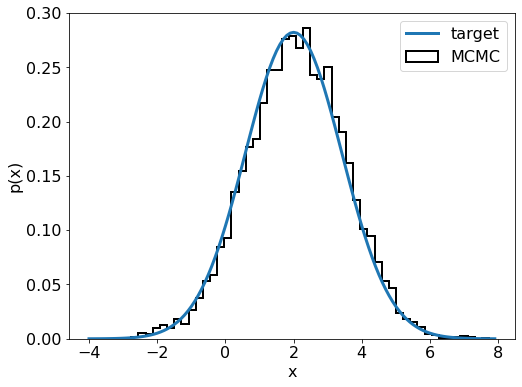

In [16]:
x_ar = np.arange(-4, 8, .1)


plt.figure(figsize = (8, 6))
plt.hist(walk, bins = 50, histtype = 'step', lw = 2, density = True, color = 'k', label = 'MCMC');
plt.plot(x_ar, target(x_ar, 2, 2), lw = 3, label = 'target')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

## 4a.) 2D Gaussian MCMC

In [17]:
def target_4a(x, mu, var):
    cov_inv = np.linalg.inv(var)
    chi2 = ((x - mu).dot(cov_inv)).dot(x - mu)
    return 1/(2*np.pi*np.sqrt(np.linalg.det(var)))*np.exp(-chi2/2)


def mh_MCMC_4a(target, step = 10000, init = np.zeros(2), var_prop = np.diag(np.ones(2)), **kwargs):
    walk = np.zeros((step + 1, 2))
    walk[0] = init
    threshold = np.random.rand(step)
    for i in range(1, step + 1):
        next_step = init + np.random.multivariate_normal(mean = np.zeros(2),
                                                         cov = var_prop)
        r = target(next_step, **kwargs)/target(init, **kwargs)
        if r > threshold[i-1]:
            init = next_step
        walk[i] = init
    return walk

In [18]:
walk_4a = mh_MCMC_4a(target_4a, mu = np.zeros(2), var = np.array([[2.0, 1.2],
                                                        [1.2, 2.0]]))

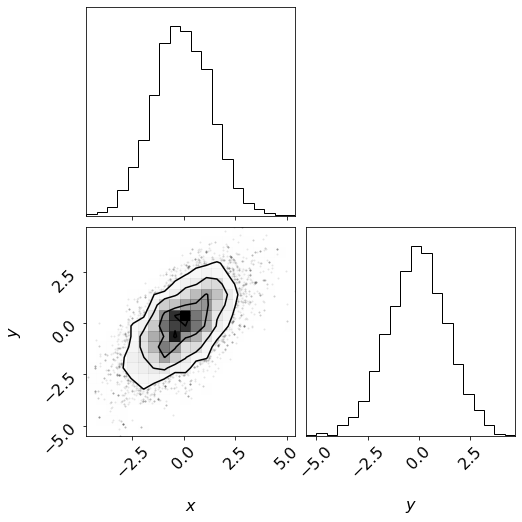

In [19]:
fig = plt.figure(figsize = (8, 8))
figure = corner.corner(walk_4a,labels=[
        r"$x$",
        r"$y$"], fig = fig);

## 4b.) 2D Flat MCMC

In [20]:
def target_4b(x, x_lim, y_lim):
    if (x[0] > x_lim[0]) and (x[0] < x_lim[1]):
        if (x[1] > y_lim[0]) and (x[1] < y_lim[1]):
            return 1/32
    return 0
    

def mh_MCMC_4b(target, step = 10000, init = np.zeros(2)+5, var_prop = np.diag(np.ones(2)), **kwargs):
    walk = np.zeros((step + 1, 2))
    walk[0] = init
    threshold = np.random.rand(step)
    for i in range(1, step + 1):
        next_step = init + np.random.multivariate_normal(mean = np.zeros(2),
                                                         cov = var_prop)
        target_init = target(init, **kwargs)
        r = target(next_step, **kwargs)/target(init, **kwargs)
        if r > threshold[i-1]:
            init = next_step
        walk[i] = init
    return walk

In [21]:
walk_4b = mh_MCMC_4b(target_4b, x_lim = (3, 7), y_lim = (1, 9))

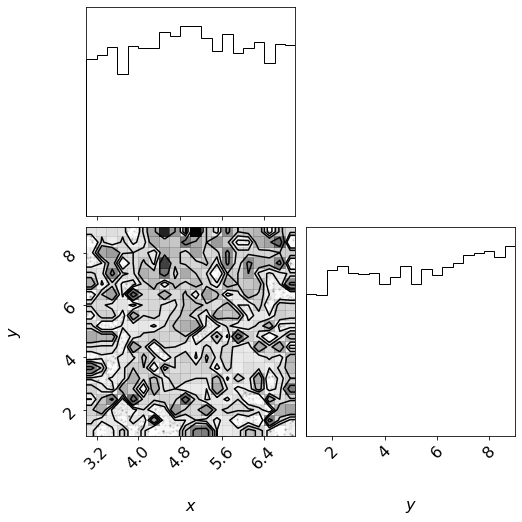

In [22]:
fig = plt.figure(figsize = (8, 8))
figure = corner.corner(walk_4b,labels=[
        r"$x$",
        r"$y$"], fig = fig);

## 5.) Convergence of 1D MCMC

In [23]:
quar = len(walk)//4

In [24]:
w1 = walk[:quar]
w2 = walk[quar:2*quar]
w3 = walk[2*quar:3*quar]
w4 = walk[3*quar:]

Text(0, 0.5, 'p(x)')

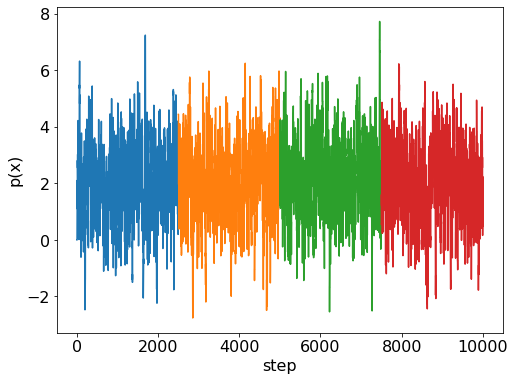

In [25]:
fig = plt.figure(figsize = (8, 6))
plt.plot(range(quar), w1)
plt.plot(range(quar,2*quar), w2)
plt.plot(range(2*quar,3*quar), w3)
plt.plot(range(3*quar,len(walk)), w4)
plt.xlabel('step')
plt.ylabel('p(x)')

In [26]:
print(np.mean(w1), np.var(w1))
print(np.mean(w2), np.var(w2))
print(np.mean(w3), np.var(w3))
print(np.mean(w4), np.var(w4))

2.0148954675699824 1.980881817336398
2.07606483767694 2.194486935226434
2.243170959890493 2.019849613538873
2.010090056136606 2.0771365154112575


The four segments all have similar mean and variance, meaning that the MCMC algorithm converges quite quickly.